In [87]:
# !pip install dotenv
# !pip install paramiko
# !pip install fabric
# !pip install pytz

In [137]:
import os
from dotenv import load_dotenv
import subprocess
import re
import pytz
from datetime import datetime
from fabric import Connection
import requests
from pathlib import Path
import logging
import shutil
import time

load_dotenv()

True

In [114]:
# Load secrets from .env
IMMICH_API_KEY = os.getenv("IMMICH_API_KEY")
IMMICH_UPLOAD_URL = str(os.getenv("IMMICH_UPLOAD_URL"))
SERVER_ADDRESS = str(os.getenv("SERVER_ADDRESS"))
SERVER_USERNAME = str(os.getenv("SERVER_USERNAME"))
SERVER_PASSWORD = str(os.getenv("SERVER_PASSWORD"))

TMP_DIR = "./tmp"
REMOTE_ROOT = f"/zstorage/surveillance_video"
HIGH_QUALITY = "30"
LOW_QUALITY = "37" #Found through testing to be a good balance of size and not losing fidelity
LOW_QUALITY = "44" #Found through testing to be a as low as I could reasonably go without loosing too much quality

DEVICE_ID = "living_room_rpi_cam"


In [115]:

# Create a connection using password authentication
conn = Connection(
    host=SERVER_ADDRESS,
    user=SERVER_USERNAME,
    connect_kwargs={
        "password": SERVER_PASSWORD
    }
)

# Verify it works
result = conn.run("hostname", hide=True)
print("Connected to:", result.stdout.strip())


Connected to: jserver


In [136]:
def convert_file(local_filepath, quality=LOW_QUALITY):
    av1_filename = os.path.basename(local_filepath).split(".")[0] + ".mkv"
    av1_filepath = f"{TMP_DIR}/{av1_filename}"
    print("Converting", local_filepath, "to", av1_filename)
    assert not os.path.exists(av1_filepath)

    try:
        result = subprocess.run(
            [
                "ffmpeg",
                "-y",
                "-hwaccel", "cuda",
                "-i", local_filepath,

                # VIDEO: NVIDIA AV1 encoder
                # "-c:v", "libaom-av1",
                # "-preset", "veryslow",
                # "-cq", "20",
                "-c:v", "av1_nvenc",
                "-preset", "p7",        # highest quality preset
                "-cq", quality,            # constant quality (lower=better)
                # "-vf", "hwupload_cuda,nvdenoise=3,hwdownload,format=yuv420p",
                # "-vf", "hqdn3d=1.5:1.5:6:6", # todo eventually look into getting a version of ffmpeg with nvidia filters, nvdenoise, nlmeans_cuda, scale_cuda, etc https://chatgpt.com/c/691b828c-9634-832b-9b9a-55fdeb3e7882
                # "-vf", "hqdn3d=0.8:0.8:3.5:3.5",
                # "-spatial-aq", "1", "-aq-strength", "8",
                # "-temporal-aq", "1",
                # "-spatial-aq", "1", "-aq-strength", "12", "-temporal-aq", "1", Didn't really notice a big difference 
                # "-denoise", "1", # not valid
                # "-rc-lookahead", "50", doesn't seem to add anything, takes up space.
                # "-film-grain", "10",

                "-b:v", "0",            # true CQ mode

                # AUDIO
                "-c:a", "copy",

                av1_filepath
            ],
            check=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE,text=True
        )
        logging.debug(result.stdout)
        logging.debug(result.stderr)
        logging.info(f"Finished [ENCODED] {av1_filepath}")
    except subprocess.CalledProcessError as e:
        logging.error(f"[ERROR] FFmpeg failed for {local_filepath}")
        logging.error(f"Return code: {e.returncode}")
        logging.error("--- FFmpeg stdout ---" + e.stdout + "--- FFmpeg stderr ---" + e.stderr)
    return av1_filepath

In [126]:
def get_time_from_filename(filename):
    tz = pytz.timezone(os.getenv("TIMEZONE", "America/Denver"))
    # Extract the first datetime-like part: YYYYMMDD_HHMMSS
    m = re.search(r"(\d{8})_(\d{6})", filename)
    date_part, time_part = m.group(1), m.group(2)

    # Parse into a datetime
    dt = datetime.strptime(f"{date_part}{time_part}", "%Y%m%d%H%M%S")
    dt = tz.localize(dt)
    return dt.isoformat()

filename = "20251029_072923_clip_000009_1.mkv"
get_time_from_filename(filename)

'2025-10-29T07:29:23-06:00'

In [142]:
def send_video_to_immich(video_filepath, timestamp="from_file"):
    print("beginning to process the request")
    video_filename = Path(video_filepath).name
    print(video_filename)
    # stats = os.stat(video_filepath)
    with open(video_filepath, 'rb') as f:
        headers = {'x-api-key': IMMICH_API_KEY}
        tz = pytz.timezone(os.getenv("TIMEZONE", "America/Denver"))
        files = {'assetData': f}
        if timestamp == "from_file":
            file_modified_at_timestamp = get_time_from_filename(video_filename)
            file_created_at_timestamp = get_time_from_filename(video_filename)
        else:
            file_modified_at_timestamp = datetime.fromtimestamp(time.time()).isoformat()
            file_created_at_timestamp = datetime.fromtimestamp(time.time()).isoformat()
        print(file_modified_at_timestamp)

        data = {
            'deviceId': DEVICE_ID,
            'deviceAssetId': video_filename,
            'fileCreatedAt': file_created_at_timestamp,
            'fileModifiedAt': file_modified_at_timestamp
        }
        print(f"Uploading video to Immich with deviceAssetId: {video_filename}")
        response = requests.post(IMMICH_UPLOAD_URL, files=files, data=data, headers=headers)
        response.raise_for_status()
        print(f"Upload response code: {response.status_code}")
        print(response.json())
        if response.json()['status'] != 'created':
            print("Something went wrong!")
            raise RuntimeError()
        else:
            return True


In [145]:
# send_video_to_immich("tmp\\clip_000000_2.mkv", timestamp=None)

In [150]:
# === List all .mp4 files in the remote directory ===
result = conn.run(f"ls {REMOTE_ROOT}/*.mp4", hide=True, warn=True)
remote_files = result.stdout.strip().splitlines()
# print(remote_files)

if result.failed or not result.stdout.strip():
    print("No .mp4 files found in remote directory.")
else:
    remote_files = result.stdout.strip().splitlines()

    print(f"Found {len(remote_files)} video(s):")
    for clip_filepath in remote_files:
        video_name = os.path.basename(clip_filepath)
        local_filepath = os.path.join(TMP_DIR, video_name)

        print(f"Downloading {video_name}...")

        # Download file
        conn.get(clip_filepath, local_filepath)

        # Delete original
        conn.run(f"rm {clip_filepath}", hide=True)

        print(f"Moved {video_name}")
        print("Converting file")
        av1_filepath = convert_file(local_filepath)

        print("File converted, now uploading")
        success = send_video_to_immich(av1_filepath)
        if success == True:
            os.remove(local_filepath)
            os.remove(av1_filepath)
        else:
            raise RuntimeError()
        print("✅ Done!\n")
        # break
# 270ish videos is 31 mins
# 32 vids is 

Found 51 video(s):
Moved 20251121_195121_clip_000001_1_partial.mp4
Converting file
Converting ./tmp\20251121_195121_clip_000001_1_partial.mp4 to 20251121_195121_clip_000001_1_partial.mkv
File converted, now uploading
beginning to process the request
20251121_195121_clip_000001_1_partial.mkv
2025-11-21T19:51:21-07:00
Uploading video to Immich with deviceAssetId: 20251121_195121_clip_000001_1_partial.mkv
Upload response code: 201
{'id': 'efed1f55-a177-4410-bfe3-9c7c991e59c6', 'status': 'created'}
✅ Done!

Moved 20251121_195135_clip_000004_1_final.mp4
Converting file
Converting ./tmp\20251121_195135_clip_000004_1_final.mp4 to 20251121_195135_clip_000004_1_final.mkv
File converted, now uploading
beginning to process the request
20251121_195135_clip_000004_1_final.mkv
2025-11-21T19:51:35-07:00
Uploading video to Immich with deviceAssetId: 20251121_195135_clip_000004_1_final.mkv
Upload response code: 201
{'id': '5d295af4-da9a-48f3-9cef-18ddf3cd8f55', 'status': 'created'}
✅ Done!

Moved 20251

In [148]:
# === List all .mp4 files in the remote directory ===
usb_src = "F:/videos/clips"
clip_files = os.listdir(usb_src)
print(f"Found {len(clip_files)} video(s):")
assert len(clip_files) > 0
for clip_filepath in clip_files:
    clip_filepath = os.path.join(usb_src, clip_filepath)
    video_name = os.path.basename(clip_filepath)
    local_filepath = os.path.join(TMP_DIR, video_name)

    print(f"Downloading {video_name}...")

    # Download file
    shutil.move(clip_filepath, local_filepath)

    print(f"Moved {video_name}")
    print("Converting file")
    av1_filepath = convert_file(local_filepath)

    print("File converted, now uploading")
    success = send_video_to_immich(av1_filepath, timestamp=None)
    if success == True:
        os.remove(local_filepath)
        os.remove(av1_filepath)
    else:
        raise RuntimeError()
    print("✅ Done!\n")
    # break
assert len(os.listdir(TMP_DIR)) == 0
# 270ish videos is 31 mins
# 32 vids is 

Found 61 video(s):
Moved clip_000000_1.mp4
Converting file
Converting ./tmp\clip_000000_1.mp4 to clip_000000_1.mkv
File converted, now uploading
beginning to process the request
clip_000000_1.mkv
2025-11-21T10:00:18.027930
Uploading video to Immich with deviceAssetId: clip_000000_1.mkv
Upload response code: 201
{'id': '1120f191-d96d-450a-b101-0d23409604ee', 'status': 'created'}
✅ Done!

Moved clip_000003_1.mp4
Converting file
Converting ./tmp\clip_000003_1.mp4 to clip_000003_1.mkv
File converted, now uploading
beginning to process the request
clip_000003_1.mkv
2025-11-21T10:00:22.404389
Uploading video to Immich with deviceAssetId: clip_000003_1.mkv
Upload response code: 201
{'id': '6466e832-6b78-4055-99cd-716073abb4fb', 'status': 'created'}
✅ Done!

Moved clip_000007_1.mp4
Converting file
Converting ./tmp\clip_000007_1.mp4 to clip_000007_1.mkv
File converted, now uploading
beginning to process the request
clip_000007_1.mkv
2025-11-21T10:00:30.559906
Uploading video to Immich with devi

In [ ]:
# get all the inap ones:
# === List all .mp4 files in the remote directory ===
result = conn.run(f"ls {REMOTE_ROOT}/inap/*.mp4", hide=True, warn=True)
remote_files = result.stdout.strip().splitlines()
# print(remote_files)

if result.failed or not result.stdout.strip():
    print("No .mp4 files found in remote directory.")
else:
    remote_files = result.stdout.strip().splitlines()

    print(f"Found {len(remote_files)} video(s):")
    for clip_filepath in remote_files:
        video_name = os.path.basename(clip_filepath)
        local_filepath = os.path.join(TMP_DIR, video_name)

        print(f"Downloading {video_name}...")

        # Download file
        conn.get(clip_filepath, local_filepath)

        # Delete original
        conn.run(f"rm {clip_filepath}", hide=True)

        print(f"Moved {video_name}")
        print("Converting file")
        av1_filepath = convert_file(local_filepath, HIGH_QUALITY)

        # print("File converted, now uploading")
        # success = send_image_to_immich(av1_filepath)
        # if success == True:
        #     os.remove(local_filepath)
        # else:
        #     raise RuntimeError()
        print("✅ Done!\n")
        # break
# 270ish videos is 31 mins
# 32 vids is 

Found 17 video(s):
Moved 20251023_175550_clip_04199_1.mp4
Converting file
✅ Done!

Moved 20251024_222449_clip_001918_1_partial.mp4
Converting file
✅ Done!

Moved 20251024_223108_clip_001937_1.mp4
Converting file
✅ Done!

Moved 20251024_223155_clip_001939_1.mp4
Converting file
✅ Done!

Moved 20251024_223248_clip_001941_1.mp4
Converting file
✅ Done!

Moved 20251024_223330_clip_001943_1.mp4
Converting file
✅ Done!

Moved 20251024_223411_clip_001945_1.mp4
Converting file
✅ Done!

Moved 20251024_223534_clip_001947_1.mp4
Converting file
✅ Done!

Moved 20251024_223639_clip_001950_1.mp4
Converting file
✅ Done!

Moved 20251024_223735_clip_001954_1.mp4
Converting file
✅ Done!

Moved 20251024_223857_clip_001958_1.mp4
Converting file
✅ Done!

Moved 20251024_224021_clip_001960_1.mp4
Converting file
✅ Done!

Moved 20251024_224147_clip_001963_1_partial.mp4
Converting file
✅ Done!

Moved 20251024_224251_clip_001966_1_partial.mp4
Converting file
✅ Done!

Moved 20251024_224352_clip_001969_1_final.mp4
Co

## Local AV1 testing:

In [3]:
import logging
import subprocess, os

In [ ]:
def encode_in_background_av1(input_path, output_path):
    """Run ffmpeg AV1 NVENC encode asynchronously."""
    logging.info("Running background encode now")
    try:
        result = subprocess.run(
            [
                "ffmpeg",
                "-y",
                "-hwaccel", "cuda",
                "-i", input_path,

                # VIDEO: NVIDIA AV1 encoder
                # "-c:v", "libaom-av1",
                # "-preset", "veryslow",
                # "-cq", "20",
                "-c:v", "av1_nvenc",
                "-preset", "p7",        # highest quality preset
                "-cq", "44",            # constant quality (lower=better)
                # "-vf", "hwupload_cuda,nvdenoise=3,hwdownload,format=yuv420p",
                "-vf", "hqdn3d=1.5:1.5:6:6", # todo eventually look into getting a version of ffmpeg with nvidia filters, nvdenoise, nlmeans_cuda, scale_cuda, etc https://chatgpt.com/c/691b828c-9634-832b-9b9a-55fdeb3e7882
                # "-vf", "hqdn3d=0.8:0.8:3.5:3.5",
                # "-spatial-aq", "1", "-aq-strength", "8",
                # "-temporal-aq", "1",
                # "-spatial-aq", "1", "-aq-strength", "12", "-temporal-aq", "1", Didn't really notice a big difference 
                # "-denoise", "1", # not valid
                # "-rc-lookahead", "50", doesn't seem to add anything, takes up space.
                # "-film-grain", "10",

                "-b:v", "0",            # true CQ mode

                # AUDIO
                "-c:a", "copy",

                output_path
            ],
            check=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE,text=True
        )
        logging.debug(result.stdout)
        logging.debug(result.stderr)
        logging.info(f"Finished [ENCODED] {output_path}")
    except subprocess.CalledProcessError as e:
        logging.error(f"[ERROR] FFmpeg failed for {input_path}")
        logging.error(f"Return code: {e.returncode}")
        logging.error("--- FFmpeg stdout ---" + e.stdout + "--- FFmpeg stderr ---" + e.stderr)

In [108]:
INPUT_DIR = "S:\Dev\\rpi-surveillence\\buffer\encode_test"
OUTPUT_DIR = "S:\Dev\\rpi-surveillence\\buffer\encode_test"

input_file = in_filepath = os.path.join(INPUT_DIR, "ref", "in_the_dark.mp4")
video_name = os.path.splitext(input_file)[0]
# out_filepath = os.path.join(OUTPUT_DIR, f"libaom-av1-p7-cq20.mkv")
out_filepath = os.path.join(OUTPUT_DIR, f"av1_nvenc-p7-cq44.mkv")
# os.makedirs(OUTPUT_DIR, exist_ok=True)
# for filename in os.listdir(INPUT_DIR):
#     in_filepath = os.path.join(INPUT_DIR, filename)
#     video_name = os.path.splitext(filename)[0]
#     # if video_name == "PXL_20230704_183209034.TS":
#     # if video_name=="audio_plus_video":
#     #     continue
#     if ".mkv" in filename:
#         continue
    # out_filepath = os.path.join(OUTPUT_DIR, f"{video_name}_av1_30.mkv")
print("Encoding", video_name, "\n\tinto", out_filepath)
encode_in_background_av1(in_filepath, out_filepath)

Encoding S:\Dev\rpi-surveillence\buffer\encode_test\ref\in_the_dark 
	into S:\Dev\rpi-surveillence\buffer\encode_test\av1_nvenc-p7-cq44.mkv


### Analysis

In [36]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_frame_at_timestamp(path, timestamp):
    """Returns the frame at the given timestamp (seconds) or None."""
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print(f"Could not open: {path}")
        return None
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        print(f"Invalid FPS for: {path}")
        return None
    
    target_frame = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Could not read frame at {timestamp}s in {path}")
        return None
    
    # Convert BGR (OpenCV) → RGB (matplotlib)
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def crop_region(frame, x, y, w, h):
    """Crops a rectangle from the frame."""
    return frame[y:y+h, x:x+w]

def compare_videos_side_by_side(
    directory,
    timestamp,
    x, y, w, h,
    file_extensions=(".mp4", ".mkv", ".h264", ".mov")
):
    """
    For all videos in a directory, extracts the same rectangle at the same timestamp,
    and displays them side-by-side.
    """

    # Collect videos
    videos = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.lower().endswith(file_extensions)
    ]

    if not videos:
        print("No video files found.")
        return

    crops = []
    labels = []

    # Extract crops
    for vid in videos:
        frame = extract_frame_at_timestamp(vid, timestamp)
        if frame is None:
            continue

        crop = crop_region(frame, x, y, w, h)
        crops.append(crop)
        labels.append(os.path.basename(vid))

    # Display side by side
    num = len(crops)
    plt.figure(figsize=(4 * num, 4))

    for i, (img, label) in enumerate(zip(crops, labels), start=1):
        ax = plt.subplot(1, num, i)
        ax.imshow(img)
        ax.set_title(label, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


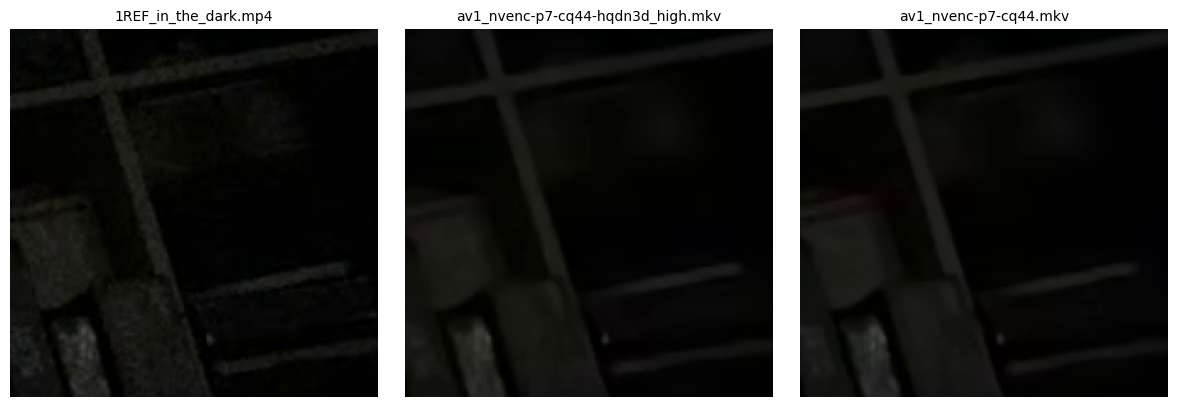

In [109]:
compare_videos_side_by_side(
    directory="S:\Dev\\rpi-surveillence\\buffer\encode_test", 
    timestamp=8.25,  # seconds
    x=1400, y=500,   # top-left corner of your crop
    w=150, h=150,    # width/height of the crop
    # timestamp=0.1,  # seconds
    # x=600, y=600,   # top-left corner of your crop
    # w=100, h=100,    # width/height of the crop
    file_extensions=(".mp4", ".mkv")
)


#Notes: 
- CQ:
  - <=46 is fine for text, there's not a huge difference up to that point. Maybe 42?
  - Basketball is fine at 46, not 50
  - ring is fine until 46, 44- is good
  - motion is a tiny bit blocky at 42, a bit more noticable at 44